# XGBoost miRNA
Runs XGBoostClassifer on miRNA data.  

Three datasets are analyzed using the XGBoost classifier:
* Sham and infeceted mice from all weeks; i.e., 8 week and 16 week datasets are merged.
* Sham and infected mice at 8 weeks.
* Sham and infected mice at 16 weeks.

In each dataset, there is a flag (named ‘infected’) that marks whether the mice came from the infected group or the sham group.  
XGBoost's variable importance and SHAP values are then used to determine which miRNA variable was most important in each cohort dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# supress sklearn warnings (hopefully)
import os
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, roc_auc_score, roc_curve, mean_absolute_error
from IPython.display import display
import random
import shap

from util import make_mirna_nanostring_df, make_study_df, param_search, param_search_cv, \
    plot_shap_feature_importance, plot_xgb_feature_importance, combine_shap_heatmaps, \
    plot_shap_summary, plot_shap_heatmap, plot_shap_dependence, plot_shap_importance_with_summary, top_shap_values

In [4]:
! python --version

Python 3.10.12


In [5]:
print('xgboost version', xgb.__version__)
print('sklearn version', sklearn.__version__)
print('shap version', shap.__version__)

xgboost version 2.1.3
sklearn version 1.5.2
shap version 0.46.0


---

## load miRNA data

In [6]:
file_names = [
    '../data/Fusobacterium_nucleatum/8 weeks F. nucleatum infection.csv',
    '../data/Fusobacterium_nucleatum/8 weeks SHAM infection.csv',
    '../data/Fusobacterium_nucleatum/16 weeks F. nucleatum infection.csv',
    '../data/Fusobacterium_nucleatum/16 weeks SHAM infection.csv',
    '../data/Porphyromonas_gingivalis/8 weeks P. gingivalis NanoString Data.csv',
    '../data/Porphyromonas_gingivalis/8 weeks SHAM RAW data.csv',
    '../data/Porphyromonas_gingivalis/16 weeks P. gingivalis  NanoString Data.csv',
    '../data/Porphyromonas_gingivalis/16 weeks SHAM RAW data.csv',
    '../data/Streptococcus_gordonii/8 weeks S.gordonii infection.csv',
    '../data/Streptococcus_gordonii/8 weeks SHAM infection.csv',
    '../data/Streptococcus_gordonii/16 weeks S. gordonii infection.csv',
    '../data/Streptococcus_gordonii/16 weeks SHAM infection.csv',
    '../data/Tannerella_forsythia/8 weeks T. forsythia bacteria infected mice RAW data.csv',
    '../data/Tannerella_forsythia/8 weeks SHAM RAW data.csv',
    '../data/Tannerella_forsythia/16 weeks T. forsythia bacteria infected mice RAW data.csv',
    '../data/Tannerella_forsythia/16 weeks SHAM RAW data.csv',
    '../data/Treponema_denticola/8 weeks T. denticola bacteria infected mice RAW data.csv',
    '../data/Treponema_denticola/8 weeks SHAM RAW data.csv',
    '../data/Treponema_denticola/16 weeks T. denticola bacteria infected mice RAW data.csv',
    '../data/Treponema_denticola/16 weeks SHAM RAW data.csv'
]
cohort_names = [
    'inf_fn_8_weeks', 'sham_fn_8_weeks', 'inf_fn_16_weeks', 'sham_fn_16_weeks',
    'inf_pg_8_weeks', 'sham_pg_8_weeks', 'inf_pg_16_weeks', 'sham_pg_16_weeks',
    'inf_sg_8_weeks', 'sham_sg_8_weeks', 'inf_sg_16_weeks', 'sham_sg_16_weeks',
    'inf_tf_8_weeks', 'sham_tf_8_weeks', 'inf_tf_16_weeks', 'sham_tf_16_weeks',
    'inf_td_8_weeks', 'sham_td_8_weeks', 'inf_td_16_weeks', 'sham_td_16_weeks'
]
list(zip(file_names, cohort_names))

[('../data/Fusobacterium_nucleatum/8 weeks F. nucleatum infection.csv',
  'inf_fn_8_weeks'),
 ('../data/Fusobacterium_nucleatum/8 weeks SHAM infection.csv',
  'sham_fn_8_weeks'),
 ('../data/Fusobacterium_nucleatum/16 weeks F. nucleatum infection.csv',
  'inf_fn_16_weeks'),
 ('../data/Fusobacterium_nucleatum/16 weeks SHAM infection.csv',
  'sham_fn_16_weeks'),
 ('../data/Porphyromonas_gingivalis/8 weeks P. gingivalis NanoString Data.csv',
  'inf_pg_8_weeks'),
 ('../data/Porphyromonas_gingivalis/8 weeks SHAM RAW data.csv',
  'sham_pg_8_weeks'),
 ('../data/Porphyromonas_gingivalis/16 weeks P. gingivalis  NanoString Data.csv',
  'inf_pg_16_weeks'),
 ('../data/Porphyromonas_gingivalis/16 weeks SHAM RAW data.csv',
  'sham_pg_16_weeks'),
 ('../data/Streptococcus_gordonii/8 weeks S.gordonii infection.csv',
  'inf_sg_8_weeks'),
 ('../data/Streptococcus_gordonii/8 weeks SHAM infection.csv',
  'sham_sg_8_weeks'),
 ('../data/Streptococcus_gordonii/16 weeks S. gordonii infection.csv',
  'inf_sg_16_

In [7]:
miRNA_df = make_mirna_nanostring_df(file_names, cohort_names)
miRNA_df.shape

(200, 604)

## create dataframes and X, y datasets

In [8]:
df_8_weeks = make_study_df(miRNA_df, cohort_str='8_weeks', infected_str='inf_')
df_16_weeks = make_study_df(miRNA_df, cohort_str='16_weeks', infected_str='inf_')
df_all_weeks = make_study_df(miRNA_df, infected_str='inf_')

In [9]:
X_8_weeks, y_8_weeks = df_8_weeks.drop('infected', axis=1), df_8_weeks['infected']
X_16_weeks, y_16_weeks = df_16_weeks.drop('infected', axis=1), df_16_weeks['infected']
X_all_weeks, y_all_weeks = df_all_weeks.drop('infected', axis=1), df_all_weeks['infected']

---

## set hyperparamaters
hyperparamaters were determined using the `all_pathogens_calculate_hyperparametersall_pathogens_calculate_hyperparameters` notebook.

In [10]:
params_8_weeks = \
    {
        'random_state': 0, 
        'objective': 'binary:logistic', 
        'n_estimators': 1000, 
        'max_depth': 150, 
        'learning_rate': 0.9, 
        'gamma': 0.3, 
        'colsample_bytree': 0.7, 
        'booster': 'gbtree'
    }

params_16_weeks = \
    {
        'random_state': 0, 
        'objective': 'binary:logistic', 
        'n_estimators': 1000, 
        'max_depth': 150, 
        'learning_rate': 0.9, 
        'gamma': 0.3, 
        'colsample_bytree': 0.7, 
        'booster': 'gbtree'
    }

params_all_weeks = \
    {
        'random_state': 0, 
        'objective': 'binary:logistic', 
        'n_estimators': 250, 
        'max_depth': 200, 
        'learning_rate': 0.1, 
        'gamma': 0.0, 
        'colsample_bytree': 0.3, 
        'booster': 'gbtree'
    }


---

### compute XGBoost models

In [11]:
model_8_weeks = xgb.XGBClassifier(**params_8_weeks).fit(X_8_weeks, y_8_weeks)
model_16_weeks = xgb.XGBClassifier(**params_16_weeks).fit(X_16_weeks, y_16_weeks)
model_all_weeks = xgb.XGBClassifier(**params_all_weeks).fit(X_all_weeks, y_all_weeks)

---

### compute SHAP values (used for explainablity)

In [12]:
explainer_8_weeks = shap.TreeExplainer(model_8_weeks, X_8_weeks, feature_names=X_8_weeks.columns.tolist())
shap_values_8_weeks = explainer_8_weeks(X_8_weeks)

explainer_16_weeks = shap.TreeExplainer(model_16_weeks, X_16_weeks, feature_names=X_16_weeks.columns.tolist())
shap_values_16_weeks = explainer_16_weeks(X_16_weeks)

explainer_all_weeks = shap.TreeExplainer(model_all_weeks, X_all_weeks, feature_names=X_all_weeks.columns.tolist())
shap_values_all_weeks = explainer_all_weeks(X_all_weeks)

---

## Bar and summary plots of feature importance
The XGBoost feature importance differs from the SHAP feature importance. They are measuring differently. See this [article](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27) for details.

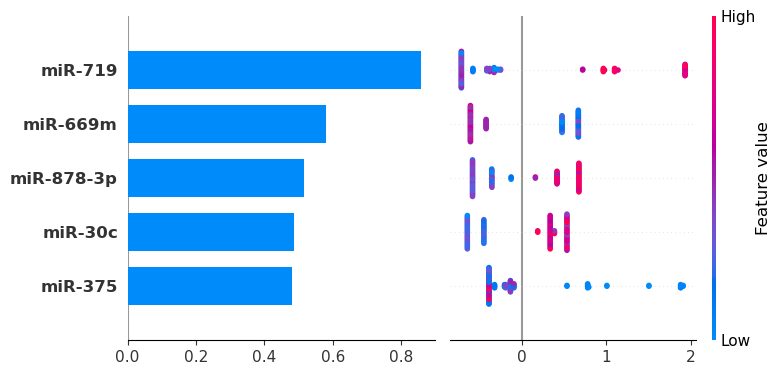

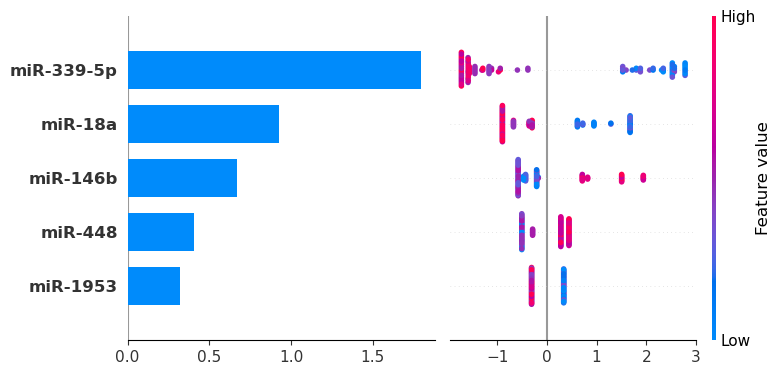

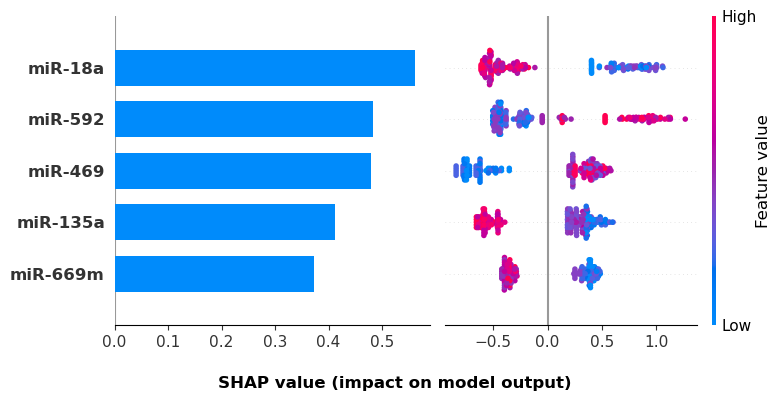

In [13]:
plot_shap_importance_with_summary(
    shap_values_8_weeks, 
    X_8_weeks, 
    title='',
    save_fig=True,
    file_name='all_pathogen_xgboost_SHAP_feature_importance_with_summary_8_weeks.png'
)

plot_shap_importance_with_summary(
    shap_values_16_weeks, 
    X_16_weeks, 
    title='',
    save_fig=True,
    file_name='all_pathogen_xgboost_SHAP_feature_importance_with_summary_16_weeks.png'
)

plot_shap_importance_with_summary(
    shap_values_all_weeks, 
    X_all_weeks, 
    title='',
    supxlabel = 'SHAP value (impact on model output)',
    save_fig=True,
    file_name='all_pathogen_xgboost_SHAP_feature_importance_with_summary_all_weeks.png'
)

## SHAP heatmaps

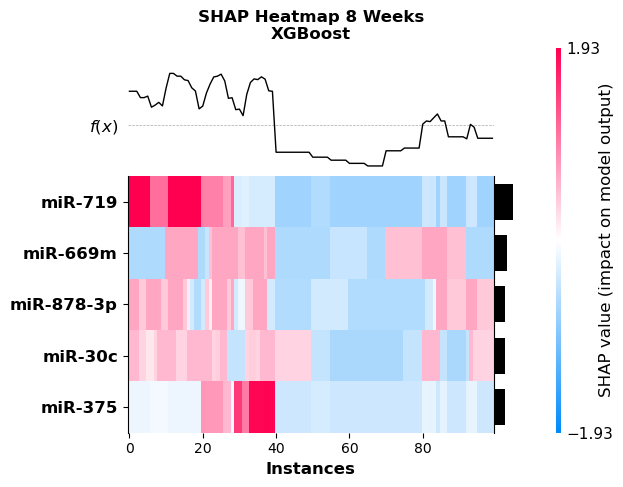

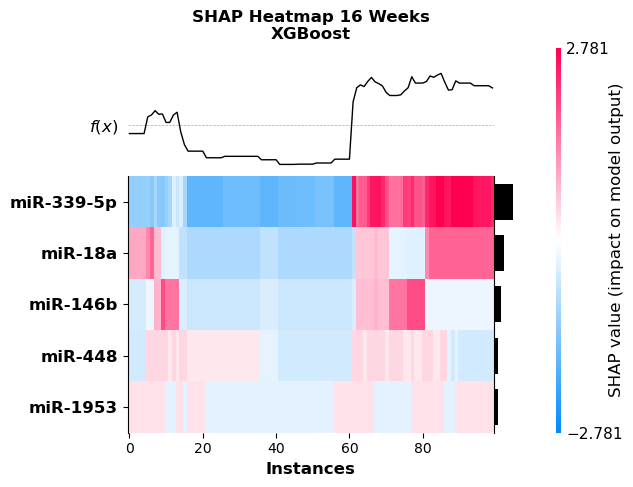

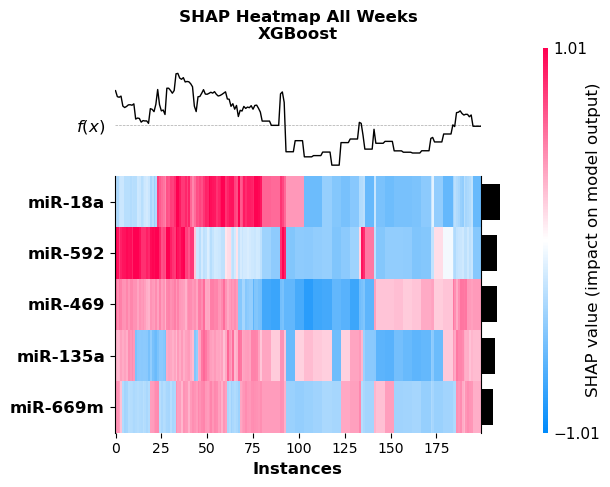

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [14]:
plot_shap_heatmap(
    top_shap_values(shap_values_8_weeks), 
    "SHAP Heatmap 8 Weeks\nXGBoost", 
    x_label='Instances',
    save_fig=True,
    file_name='all_pathogen_xgboost_SHAP_Heatmap_8_Weeks.png'
)

plot_shap_heatmap(
    top_shap_values(shap_values_16_weeks), 
    "SHAP Heatmap 16 Weeks\nXGBoost", 
    x_label='Instances',
    save_fig=True,
    file_name='all_pathogen_xgboost_SHAP_Heatmap_16_Weeks.png'
)

plot_shap_heatmap(
    top_shap_values(shap_values_all_weeks), 
    "SHAP Heatmap All Weeks\nXGBoost", 
    x_label='Instances',
    save_fig=True,
    file_name='all_pathogen_xgboost_SHAP_Heatmap_All_Weeks.png'
)

## SHAP dependence plots

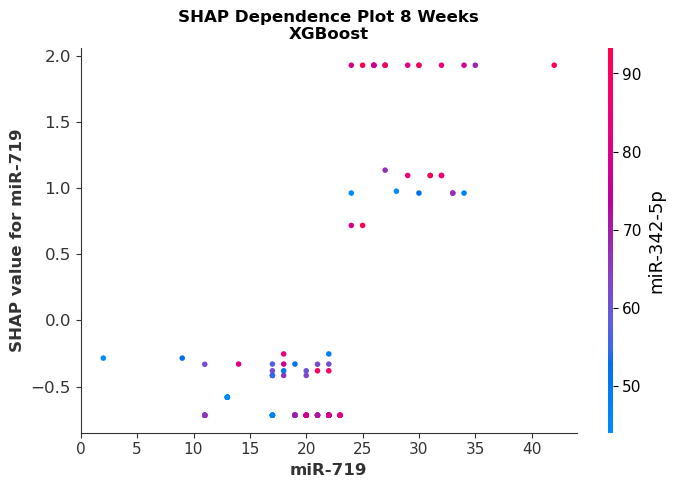

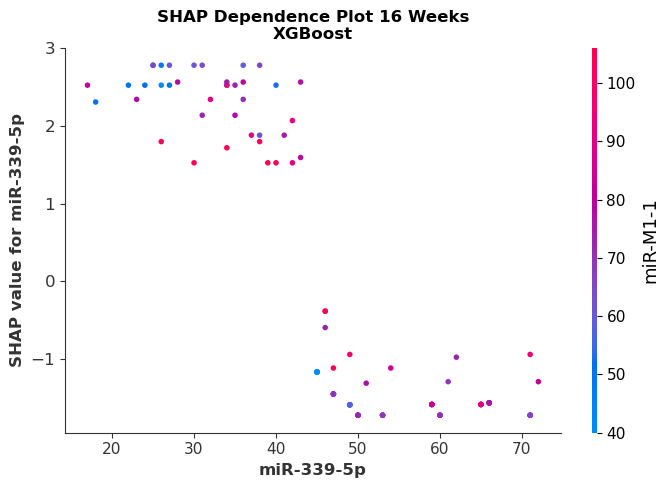

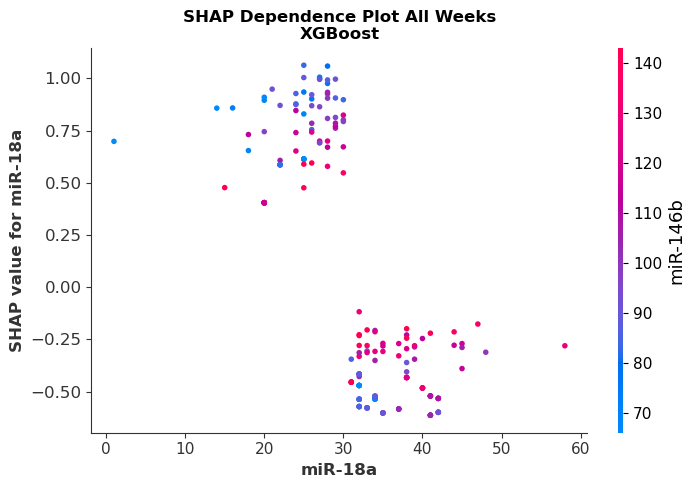

In [15]:
plot_shap_dependence(
    shap_values_8_weeks, 
    X_8_weeks, 
    "SHAP Dependence Plot 8 Weeks\nXGBoost", 
    save_fig=True,
    file_name='all_pathogen_xgboost_SHAP_Dependence_Plot_8_Weeks.png'
)

plot_shap_dependence(
    shap_values_16_weeks, 
    X_16_weeks, 
    "SHAP Dependence Plot 16 Weeks\nXGBoost", 
    save_fig=True,
    file_name='all_pathogen_xgboost_SHAP_Dependence_Plot_16_Weeks.png'
)

plot_shap_dependence(
    shap_values_all_weeks, 
    X_all_weeks, 
    "SHAP Dependence Plot All Weeks\nXGBoost", 
    save_fig=True,
    file_name='all_pathogen_xgboost_SHAP_Dependence_Plot_All_Weeks.png'
)